In [1]:
import pandas as pd
import tensorflow as tf
import numpy
import pickle as pkl
import os
os.chdir(os.path.join(os.getcwd(), ".."))
import finviz as fz
import yfinance as yf
import calendar
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, log_loss
from sklearn.metrics import PrecisionRecallDisplay

from src.utils import data_layer, get_dataset, hist_multi_plot, 

%load_ext autoreload
%autoreload 2

In [2]:
perc_space = 0.8
perc_time = 0.8

WINDOW_SIZE = 21 # Include window + target
BATCH_SIZE = 8

data_path = os.path.join(os.getcwd(), "data")
sp_100_file = os.path.join(data_path, "sp-100-index-07-02-2020.csv")

# Load and Data formatting

In [88]:
def infer_year(current_month, current_year):
    dict_cont = {}
    dict_cont["current_year"] = current_year
    dict_cont["previous_month"] = current_month
    def _infer_year(x):
        delta_months = dict_cont["previous_month"] - x
        if x>=1 and delta_months>=0:
            dict_cont["previous_month"] = x
        else:
            dict_cont["previous_month"] = x
            dict_cont["current_year"]-=1
        return dict_cont["current_year"]
    return _infer_year

def data_layer(sp_100_file, data_path, perc_space, perc_time):
    sp_100_df = pd.read_csv(sp_100_file)
    simbols = sp_100_df.Symbol.values[:-1]
    map_month2month_number = dict((v,k) for k,v in enumerate(calendar.month_abbr))
    stock = {}
    cont = 0
    avg_amount = pd.DataFrame()
    ordered_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Perc_sp100', 'volatility', 
                       'change_price_beg_end', 'change_price', 'Volume_rel_price', 'Vol_rel_volatility',
                       'Dividends', 'Stock Splits', 'Buy', 'Sale', 'Option Exercise']
    for simbol in simbols:
        try:
            insider_info = fz.get_insider(simbol)
            insider_data = pd.DataFrame.from_dict(insider_info)
            insider_data[["month_name", "day"]]= insider_data.Date.str.split(" ", expand=True)
            insider_data["month"] = insider_data["month_name"].map(map_month2month_number)
            insider_data["year"] = insider_data["month"].apply(infer_year(datetime.datetime.now().month,
                                                                        datetime.datetime.now().year))
            insider_data["date"] = pd.to_datetime(insider_data[["year", "month", "day"]], format="%y%m%d") 
            cont = cont + 1
        except Exception as inst:
            print(simbol, end=" ")
            print(type(inst), end=" ")# the exception instance
            print(inst) 
            continue
        curr_ticker = yf.Ticker(simbol)
        curr_hist = curr_ticker.history(period="1y")
        curr_table = pd.pivot_table(insider_data,
                                    index=['date'],
                                    columns=['Transaction'], aggfunc={"Transaction": len})
        curr_hist["volatility"] = (curr_hist.High - curr_hist.Low)/(curr_hist.Open + np.finfo(float).eps)
        curr_hist["change_price_beg_end"] = curr_hist.Open - curr_hist.Close
        curr_hist["change_price"] = curr_hist.High - curr_hist.Low
        curr_hist["Volume_rel_price"] = curr_hist.Volume*curr_hist["change_price"]
        curr_hist["Vol_rel_volatility"] = curr_hist.Volume*curr_hist["volatility"]
        curr_table = ~curr_table.isnull()
        curr_table.columns = [col[1] for col in curr_table.columns]
        curr_hist = curr_hist.merge(curr_table, how="left", left_index=True, right_index=True)
        curr_hist = curr_hist.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
        curr_hist = curr_hist.fillna(False)
        if "Buy" not in curr_hist.columns:
            curr_hist["Buy"] = False
        if "Sale" not in curr_hist.columns:
            curr_hist["Sale"] = False
        if "Option Exercise" not in curr_hist.columns:
            curr_hist["Option Exercise"] = False
        stock[simbol] = curr_hist
        stock[simbol]["Amount_negotiated"] = stock[simbol]["Volume"]*stock[simbol]["Close"]
        avg_amount[simbol] = stock[simbol]["Amount_negotiated"]
        
    avg_amount_mean = avg_amount.mean(axis=1)
    for key, val in stock.items():
        stock[key]["Perc_sp100"] = stock[key]["Volume"]*stock[key]["Close"]/avg_amount_mean
        stock[key] = stock[key][ordered_columns]
    return stock

In [89]:
stock = data_layer(sp_100_file, data_path, perc_space, perc_time)

BKNG <class 'IndexError'> list index out of range
BRK.B <class 'requests.exceptions.HTTPError'> 404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=BRK.B
C <class 'IndexError'> list index out of range
DD <class 'IndexError'> list index out of range
EXC <class 'IndexError'> list index out of range
GOOGL <class 'IndexError'> list index out of range
GS <class 'IndexError'> list index out of range
MO <class 'IndexError'> list index out of range
RTX <class 'IndexError'> list index out of range


In [90]:
n_train_space = int(len(stock.keys())*perc_space)
n_train_out_space = len(stock.keys())-n_train_space

In [91]:
train_space = np.random.choice(list(stock.keys()), size=n_train_space, replace=False).tolist()
test_space = list(set(stock.keys()) - set(train_space))
samples = stock["AAPL"].shape[0]
train_samples = int((samples-WINDOW_SIZE)*perc_time)

# Data loader object

In [92]:
train_ds, val_ds = get_dataset(stock, train_space, train_samples=train_samples, window_size=WINDOW_SIZE)

Companies:  ['GD', 'JNJ', 'QCOM', 'NFLX', 'COP', 'AIG', 'MMM', 'NKE', 'SO', 'DHR', 'GE', 'KMI', 'OXY', 'BMY', 'USB', 'COF', 'KO', 'MS', 'TGT', 'GOOG', 'PYPL', 'BA', 'AMT', 'UPS', 'BK', 'SPG', 'ORCL', 'NEE', 'F', 'FB', 'DUK', 'GM', 'ABT', 'WMT', 'DIS', 'LOW', 'TXN', 'MRK', 'UNP', 'IBM', 'CVS', 'PEP', 'KHC', 'AMGN', 'VZ', 'MA', 'BIIB', 'LMT', 'HON', 'T', 'ACN', 'LLY', 'CVX', 'ADBE', 'EMR', 'AMZN', 'GILD', 'PFE', 'PM', 'CRM', 'V', 'CSCO', 'CL', 'SBUX', 'MCD', 'MDT', 'WBA', 'CAT', 'INTC', 'AXP', 'BAC', 'CMCSA', 'ABBV']


In [93]:
test_ds = get_dataset(stock, test_space, train_samples=None, window_size=WINDOW_SIZE)

Companies:  ['MSFT', 'WFC', 'MDLZ', 'COST', 'AAPL', 'NVDA', 'CHTR', 'BLK', 'SLB', 'DOW', 'PG', 'UNH', 'MET', 'FDX', 'ALL', 'TMO', 'HD', 'XOM', 'JPM']


In [94]:
train_ds = train_ds.shuffle(buffer_size=8000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(16)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [95]:
a = iter(train_ds)
next(a)

((<tf.Tensor: shape=(8, 20, 16), dtype=float64, numpy=
  array([[[ 54.68,  55.47,  53.99, ...,   0.  ,   0.  ,   0.  ],
          [ 55.12,  55.92,  54.72, ...,   0.  ,   1.  ,   1.  ],
          [ 55.82,  56.18,  55.58, ...,   0.  ,   0.  ,   0.  ],
          ...,
          [ 56.41,  56.68,  56.07, ...,   0.  ,   0.  ,   0.  ],
          [ 56.52,  57.99,  56.48, ...,   0.  ,   0.  ,   1.  ],
          [ 58.18,  58.82,  57.91, ...,   0.  ,   1.  ,   1.  ]],
  
         [[116.51, 117.57, 115.97, ...,   0.  ,   0.  ,   0.  ],
          [116.49, 117.54, 115.62, ...,   0.  ,   0.  ,   0.  ],
          [115.92, 116.65, 114.18, ...,   0.  ,   0.  ,   0.  ],
          ...,
          [112.88, 114.89, 112.62, ...,   0.  ,   0.  ,   0.  ],
          [112.94, 114.29, 112.94, ...,   0.  ,   0.  ,   0.  ],
          [114.55, 115.63, 114.41, ...,   0.  ,   0.  ,   0.  ]],
  
         [[ 59.35,  59.4 ,  58.8 , ...,   0.  ,   0.  ,   0.  ],
          [ 59.21,  59.58,  59.04, ...,   0.  ,   0.  ,   0.  

# Model

In [96]:
def build_model():
    inputs = tf.keras.Input(shape=(20,16))
    x = tf.keras.layers.BatchNormalization(axis=2)(inputs)
    x_0 = tf.keras.layers.GRU(64, return_sequences=False)(x)
    x_1 = tf.keras.layers.GRU(64, return_sequences=False)(x)
    x = tf.keras.layers.Concatenate()([x_0, x_1])
    x = tf.keras.layers.BatchNormalization()(x)
    sigmoids = tf.keras.layers.Dense(3, activation="sigmoid")(x)
    outputs = tf.keras.backend.expand_dims(sigmoids, axis=1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [97]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 16)       64          input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 64)           15744       batch_normalization[0][0]        
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 64)           15744       batch_normalization[0][0]        
______________________________________________________________________________________________

In [98]:
model.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC", tf.keras.metrics.AUC(curve="PR", name="PR_AUC")])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',#val_loss
                                               patience=2,
                                               mode='min',
                                               restore_best_weights=True)

In [99]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=20, 
                    callbacks = [es_callback])

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1689/1689 [==============================] - 26s 16ms/step - loss: 0.1594 - accuracy: 0.0980 - auc: 0.6716 - PR_AUC: 0.0626 - val_loss: 0.0927 - val_accuracy: 0.0365 - val_auc: 0.8252 - val_PR_AUC: 0.3502
Epoch 2/20
1689/1689 [==============================] - 37s 22ms/step - loss: 0.1197 - accuracy: 0.0692 - auc: 0.7413 - PR_AUC: 0.1473 - val_loss: 0.1008 - val_accuracy: 0.0451 - val_auc: 0.7623 - val_PR_AUC: 0.3402
Epoch 3/20
1689/1689 [==============================] - 31s 18ms/step - loss: 0.1182 - accuracy: 0.0772 - auc: 0.7625 - PR_AUC: 0.1484 - val_loss: 0.0955 - val_accuracy: 0.0622 - val_auc: 0.8397 - val_PR_AUC: 0.2597


In [100]:
model.evaluate(test_ds)

554/554 [==============================] - 3s 5ms/step - loss: 0.1132 - accuracy: 0.0535 - auc: 0.7612 - PR_AUC: 0.1256


[0.11315745860338211,
 0.05353512614965439,
 0.7612084150314331,
 0.12563152611255646]

# Comparing predictions and looking if it is learning anything
dataframe start from the 20, example df[20:] are all the samples in test, and each company has ~232 records, so to iterate would be accooording to 232 and addding 20 to the origiinal df

In [101]:
y_test = []
for sample in test_ds:
    y_test.append(sample[1].numpy())
y_test = np.squeeze(np.concatenate(y_test))

In [102]:
out = model.predict(test_ds)
out = np.squeeze(out)
aux_stock = {}
cont = 0
for idx, company in enumerate(test_space):
    print("Company: ", company)
    curr_hist = stock[company]
    curr_index = curr_hist.index[WINDOW_SIZE-1:]
    curr_size = len(curr_index)
    pred_df = pd.DataFrame(out[cont:cont+curr_size],
                           index=curr_hist.index[WINDOW_SIZE-1:],
                           columns=["Pred_Buy", "Pred_Option", "Pred_Sale"])
    aux_stock[company] = stock[company].merge(pred_df, how="left", 
                                              left_index=True, right_index=True)
    cont = cont + curr_size

Company:  MSFT
Company:  WFC
Company:  MDLZ
Company:  COST
Company:  AAPL
Company:  NVDA
Company:  CHTR
Company:  BLK
Company:  SLB
Company:  DOW
Company:  PG
Company:  UNH
Company:  MET
Company:  FDX
Company:  ALL
Company:  TMO
Company:  HD
Company:  XOM
Company:  JPM


In [103]:
df = pd.DataFrame(np.concatenate([out, y_test], axis=1), 
             columns=["pred_Buy", "pred_Option", "pred_Sale", "Buy", "Option", "Sale"])

In [104]:
means = df.mean()

# Metrics

Average Precision:  0.010835968561982715
Strawman Crossentropy 0.041720669601262764
Binary Crossentropy 0.04407000022082522


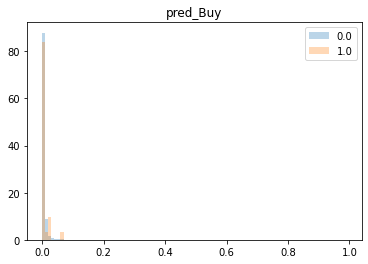

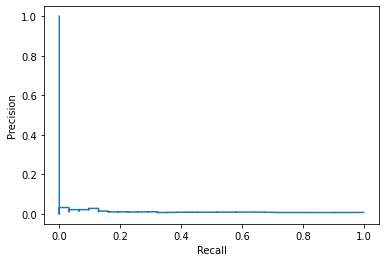

In [105]:
pred_col = "pred_Buy"
col = "Buy"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

Average Precision:  0.06152576250758002
Strawman Crossentropy 0.10366509320611689
Binary Crossentropy 0.1014334942695975


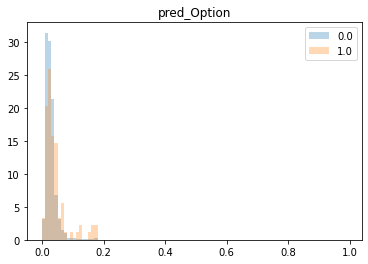

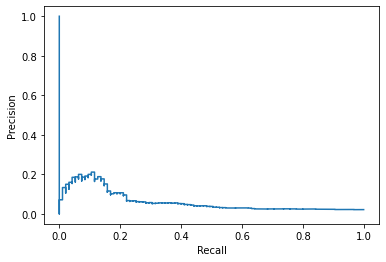

In [106]:
pred_col = "pred_Option"
col = "Option"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

Average Precision:  0.1704913368401367
Strawman Crossentropy 0.2087954929155983
Binary Crossentropy 0.19396977538777002


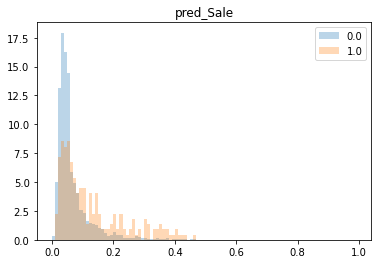

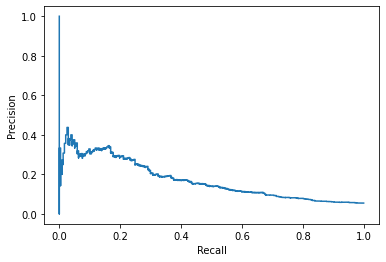

In [107]:
pred_col = "pred_Sale"
col = "Sale"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)